In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
df = pd.read_csv("/home/harshit/Downloads/project/prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close 
df.drop(['close'], 1, inplace=True) 
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [16]:
df2 = pd.read_csv("/home/harshit/Downloads/project/fundamentals.csv")
df2.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [17]:
symbols = list(set(df.symbol))
len(symbols)

501

In [18]:
symbols[:11] 

['AGN',
 'EOG',
 'CPB',
 'EVHC',
 'IDXX',
 'SIG',
 'JWN',
 'JBHT',
 'TAP',
 'VRTX',
 'BWA']

In [19]:
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,312.304948,310.955001,313.580158,3927000.0,312.205308
2010-01-05,312.419511,309.610028,312.748278,6031900.0,310.830459
2010-01-06,311.761979,302.048370,311.761979,7987100.0,302.994813
2010-01-07,303.562685,295.218951,303.861575,12876600.0,295.941242
2010-01-08,294.895159,293.455551,300.499172,9483900.0,299.886470


In [20]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.157047,0.161167,0.156390,0.131722,0.159399
2010-01-05,0.157238,0.158884,0.154995,0.202469,0.157092
2010-01-06,0.156140,0.146049,0.153341,0.268184,0.143942
2010-01-07,0.142436,0.134457,0.140094,0.432522,0.132105
2010-01-08,0.127950,0.131464,0.134455,0.318492,0.138726


In [21]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) 
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 
    result = []
    
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [70]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [71]:
window = 22
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train[0], y_train[0])

(array([[3.12304948e+02, 3.10955001e+02, 3.13580158e+02, 3.92700000e+06,
        3.12205308e+02],
       [3.12419511e+02, 3.09610028e+02, 3.12748278e+02, 6.03190000e+06,
        3.10830459e+02],
       [3.11761979e+02, 3.02048370e+02, 3.11761979e+02, 7.98710000e+06,
        3.02994813e+02],
       [3.03562685e+02, 2.95218951e+02, 3.03861575e+02, 1.28766000e+07,
        2.95941242e+02],
       [2.94895159e+02, 2.93455551e+02, 3.00499172e+02, 9.48390000e+06,
        2.99886470e+02],
       [3.01101926e+02, 2.95911366e+02, 3.01101926e+02, 1.44798000e+07,
        2.99433161e+02],
       [2.97709617e+02, 2.92902633e+02, 2.97963676e+02, 9.74290000e+06,
        2.94138017e+02],
       [2.87169102e+02, 2.85878939e+02, 2.93091933e+02, 1.30418000e+07,
        2.92449324e+02],
       [2.90860270e+02, 2.90317331e+02, 2.95991047e+02, 8.51190000e+06,
        2.93824173e+02],
       [2.95562671e+02, 2.87941229e+02, 2.95672260e+02, 1.09096000e+07,
        2.88917549e+02],
       [2.89515328e+02, 2.870

In [72]:
model = build_model([5,window,1])

('Compilation Time : ', 0.01915907859802246)


In [73]:
model.fit(X_train,y_train,batch_size=512,epochs=150,validation_split=0.1,verbose=1)


Train on 1408 samples, validate on 157 samples
Epoch 1/150
1408/1408 [==============================] - 5s 3ms/step - loss: 173847.5540 - acc: 0.0000e+00 - val_loss: 506232.9062 - val_acc: 0.0000e+00
Epoch 2/150
1408/1408 [==============================] - 3s 2ms/step - loss: 173651.4673 - acc: 0.0000e+00 - val_loss: 505782.2188 - val_acc: 0.0000e+00
Epoch 3/150
1408/1408 [==============================] - 3s 2ms/step - loss: 173372.4489 - acc: 0.0000e+00 - val_loss: 505120.0000 - val_acc: 0.0000e+00
Epoch 4/150
1408/1408 [==============================] - 3s 2ms/step - loss: 172942.8764 - acc: 0.0000e+00 - val_loss: 504148.5938 - val_acc: 0.0000e+00
Epoch 5/150
1408/1408 [==============================] - 4s 3ms/step - loss: 172376.7131 - acc: 0.0000e+00 - val_loss: 503061.0312 - val_acc: 0.0000e+00
Epoch 6/150
1408/1408 [==============================] - 3s 2ms/step - loss: 171745.2571 - acc: 0.0000e+00 - val_loss: 501818.7500 - val_acc: 0.0000e+00
Epoch 7/150
1408/1408 [============

KeyboardInterrupt: 

In [58]:
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(174, 1)


In [59]:
df = pd.read_csv("/home/harshit/Downloads/project/prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)

# the denormalize function 
def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [60]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00019 MSE (0.01 RMSE)
Test Score: 0.00031 MSE (0.02 RMSE)


(0.00019212337171721359, 0.000312879041637476)

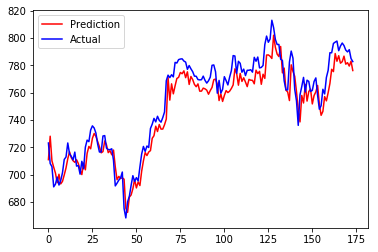

In [61]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()